In [487]:
from validator.InstanceCO22 import InstanceCO22
from util import *
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from vrpy import VehicleRoutingProblem
import pprint
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Approach
1. assign location to closest hub 
2. determine optimal route per hub
3. Determine truck routes using hub need

In [450]:
instance = loadInstance(2)

In [451]:
def computeDistanceMatrix(instance: InstanceCO22, roundUp: bool = True) -> np.ndarray:
    # https://stackoverflow.com/questions/22720864/efficiently-calculating-a-euclidean-distance-matrix-using-numpy
        
    z = np.array([complex(l.X, l.Y) for l in instance.Locations])
    m, n = np.meshgrid(z, z)
    out = abs(m-n)
    if roundUp:
        out = np.ceil(out)
    return out


In [452]:
def assignHub(distanceMatrix: np.ndarray, hubs: list, nDepot: int = 1)-> np.ndarray:
    # Take distance matrix and assign to each point the closest hub 
    # hubs: list of indices containing place of the hubs in the distanceMatrix
    # Returns array with hub indice for each location (starting with 0). Includes depot and hubs

    hubDistanceMatrix =  distanceMatrix[hubs]
    assignedHub =  np.argmin(hubDistanceMatrix, axis=0)
    return assignedHub

In [453]:
def pointsPerHub(assignedHub: np.ndarray) -> np.ndarray:
    #List of indices per hub
    sort_idx = np.argsort(assignedHub)
    a_sorted = assignedHub[sort_idx]
    unq_first = np.concatenate(([True], a_sorted[1:] != a_sorted[:-1]))
    unq_count = np.diff(np.nonzero(unq_first)[0])
    unq_idx = np.split(sort_idx, np.cumsum(unq_count))
    return unq_idx

In [454]:
def filterRequests(instance, day = None, locationsID = None):
    res = instance.Requests.copy()
    if day != None:
        res = [_ for _ in res if _.desiredDay is day]
    if locationsID != None:
        res = [_ for _ in res if _.customerLocID in locationsID]
    return res


In [455]:
def locationsWithRequest(locations, requests):
    loc_ids = [_.customerLocID for _ in requests]
    return [_ for _ in locations if _.ID in loc_ids]

In [456]:
%%time
distanceMatrix = computeDistanceMatrix(instance,roundUp=True)
assignedHub = assignHub(distanceMatrix, hubs=[1,2])
pointsPerHub(assignedHub)

CPU times: user 415 µs, sys: 503 µs, total: 918 µs
Wall time: 849 µs


[array([ 1, 16, 21]),
 array([ 0, 20, 19, 18, 17, 15, 14, 13, 12, 11,  9,  8,  7,  6,  5,  4,  3,
         2, 10, 22])]

In [457]:
def plotInstanceClusters(instance):
    nHubs = len(instance.Hubs)
    hubs = [_ for _ in range(1,nHubs+1)]
    distanceMatrix = computeDistanceMatrix(instance,roundUp=True)
    assignedHubs = assignHub(distanceMatrix, hubs=hubs)
    hubPoints = pointsPerHub(assignedHubs)
    locX = [_.X for _ in instance.Locations]
    locY = [_.Y for _ in instance.Locations]

    #plt.figure(figsize=(7,7))

    for i, hub in enumerate(hubPoints):
        hubX = [locX[i] for i in hub]
        hubY = [locY[i] for i in hub]
        plt.scatter(hubX, hubY, marker=".", label= f"Hub{i}")

    plt.scatter(locX[1:1+nHubs], locY[1:1+nHubs],marker="^", label="Hub")
    plt.scatter(locX[0], locY[0], marker=",", label="Depot")
    plt.legend(loc=(1.04,0))

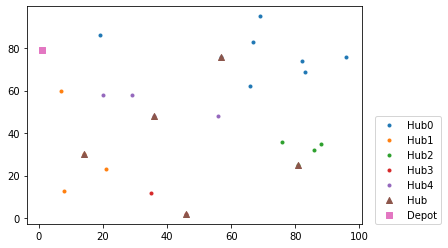

In [448]:

plotInstanceClusters(instance)

In [483]:
def toNetworkX_hubschedule(clientLocations, requests, hub=None):
    locations = clientLocations
    locations = locations + [hub]
    G = nx.DiGraph()
    for loc in locations:
        if loc.ID is hub.ID:
            G.add_node("Source")
            G.add_node("Sink")
        else:
            G.add_node(loc.ID)

    for req in requests:
        if req in G.nodes.keys():
            G.nodes[req.customerLocID]['demand'] = sum(req.amounts)

    for l1 in locations:
        for l2 in locations:
            if l1.ID != l2.ID:
                dist = math.ceil( math.sqrt( pow(l1.X-l2.X,2) + pow(l1.Y-l2.Y,2) ))
                if l1.ID != hub.ID and l2.ID != hub.ID: 
                    G.add_edge(l1.ID, l2.ID, time = dist, cost=dist)
                elif l1.ID == hub.ID:
                    G.add_edge("Source", l2.ID, time = dist, cost=dist)
                elif l2.ID == hub.ID:
                    G.add_edge(l1.ID, "Sink", time = dist, cost=dist)
    pos = {_.ID:[_.X,_.Y] for _ in locations}
    pos['Source'] = [hub.X,hub.Y]
    pos['Sink'] = [hub.X,hub.Y]
    return G, pos

In [239]:
#locations = instance.Locations
requests = filterRequests(instance, day=1)
locations = locationsWithRequest(instance.Locations, requests)
hub = instance.Locations[1]
G, pos = toNetworkX_hubschedule(locations, requests, hub)

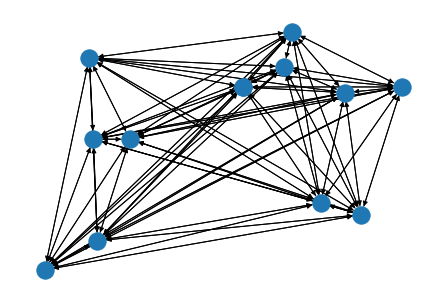

In [240]:
#pos = {_.ID:[_.X,_.Y] for _ in locations}

nx.draw(G,pos=pos)

In [241]:
prob = VehicleRoutingProblem(G, load_capacity=instance.VanCapacity)
prob.duration = instance.VanMaxDistance
prob.solve()

INFO:vrpy.vrp:new upper bound : max num stops = 13
INFO:vrpy.vrp:Clarke & Wright solution found with value 349 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 384 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 349.0
INFO:vrpy.vrp:iteration 1, 349.0
INFO:vrpy.vrp:iteration 2, 349.0
INFO:vrpy.vrp:iteration 3, 349.0
INFO:vrpy.vrp:iteration 4, 349.0
INFO:vrpy.vrp:iteration 5, 349.0
INFO:vrpy.vrp:iteration 6, 349.0
INFO:vrpy.vrp:iteration 7, 349.0
INFO:vrpy.vrp:iteration 8, 349.0
INFO:vrpy.vrp:iteration 9, 349.0
INFO:vrpy.vrp:iteration 10, 349.0
INFO:vrpy.vrp:iteration 11, 349.0
INFO:vrpy.vrp:iteration 12, 349.0
INFO:vrpy.vrp:iteration 13, 349.0
INFO:vrpy.vrp:iteration 14, 349.0
INFO:vrpy.vrp:iteration 15, 349.0
INFO:vrpy.vrp:iteration 16, 349.0
INFO:vrpy.vrp:iteration 17, 349.0
INFO:vrpy.vrp:iteration 18, 349.0
INFO:vrpy.vrp:iteration 19, 349.0
INFO:vrpy.vrp:iteration 20, 349.0
INFO:vrpy.vrp:iteration 21, 349.0
INFO:vrpy.vrp:iteration 22, 349.0
INFO:vrpy.vrp:iteration 23, 349.0
IN

In [242]:
prob.best_routes

{1: ['Source', 11, 21, 8, 15, 14, 22, 13, 19, 16, 7, 20, 'Sink']}

In [247]:
def plotRoute(locations, route, hub):
    #route: ['Source', 11, 21, 20, 16, 7, 13, 19, 22, 14, 15, 'Sink']}
    for i in range(0,len(route)-1):
        p1 = route[i]
        p2 = route[i+1]
        if p1 == 'Source' or p1 == 'Sink':
            loc1 = (hub.X,hub.Y)
        else:
            loc1 = [_ for _ in locations if _.ID is p1][0]
            loc1 = (loc1.X,loc1.Y)

        if p2 == 'Source' or p2 == 'Sink':
            loc2  = (hub.X,hub.Y)
        else:
            loc2 = [_ for _ in locations if _.ID is p2][0]
            loc2 = (loc2.X,loc2.Y)
        plt.plot([loc1[0],loc2[0]],[loc1[1],loc2[1]])

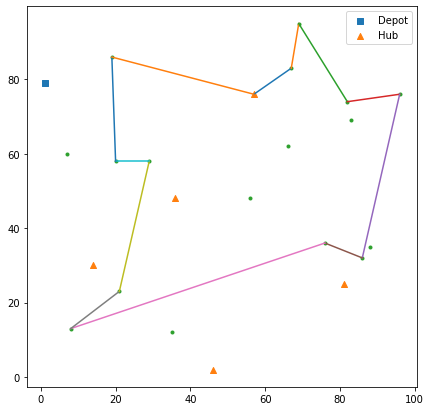

In [248]:
plotInstance(instance)
plotRoute(locations, prob.best_routes[1], hub=hub)

In [509]:
def toNetworkX_depotschedule(hubs, depot, demands):
    locations = hubs
    locations = locations + [depot]
    G = nx.DiGraph()
    for loc in locations:
        if loc.ID is depot.ID:
            G.add_node("Source")
            G.add_node("Sink")
        else:
            G.add_node(loc.ID)

    for ID, v in demands.items():
        G.nodes[ID]['demand'] = v['demand']

    for l1 in locations:
        for l2 in locations:
            if l1.ID != l2.ID:
                dist = math.ceil( math.sqrt( pow(l1.X-l2.X,2) + pow(l1.Y-l2.Y,2) ))
                if l1.ID != depot.ID and l2.ID != depot.ID: 
                    G.add_edge(l1.ID, l2.ID, time = dist, cost=dist)
                elif l1.ID == depot.ID:
                    G.add_edge("Source", l2.ID, time = dist, cost=dist)
                elif l2.ID == depot.ID:
                    G.add_edge(l1.ID, "Sink", time = dist, cost=dist)
    pos = {_.ID:[_.X,_.Y] for _ in locations}
    pos['Source'] = [depot.X,depot.Y]
    pos['Sink'] = [depot.X,depot.Y]
    return G, pos


INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 151 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 151 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 151.0
INFO:vrpy.vrp:iteration 1, 151.0
INFO:vrpy.vrp:iteration 2, 151.0
INFO:vrpy.master_solve_pulp:total cost = 151.0


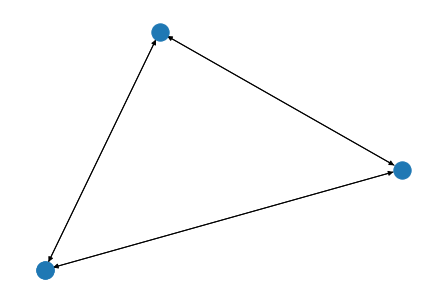

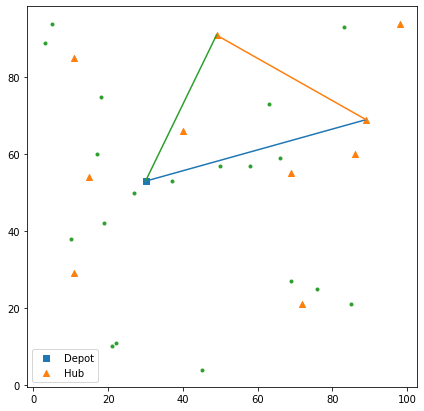

In [513]:
hubs = instance.Locations[2:4]
depot = instance.Locations[0]
demands = {3: {'demand': 4, 'routes': {1: [7, 14, 7]}},
           4: {'demand': 5, 'routes': {1: [8, 21, 8]}}}
G, pos = toNetworkX_depotschedule(hubs, depot, demands)
nx.draw(G, pos=pos)
prob = VehicleRoutingProblem(G, load_capacity=instance.VanCapacity)
prob.duration = instance.TruckMaxDistance
prob.solve()
plotInstance(instance)
plotRoute(hubs, prob.best_routes[1], hub=depot)

In [516]:
def sol1(instance):
    #hub routes
    distanceMatrix = computeDistanceMatrix(instance,roundUp=True)
    nHubs = len(instance.Hubs)
    hubs = [_ for _ in range(1,nHubs+1)]
    assignedHub = assignHub(distanceMatrix, hubs=hubs)
    hubs = pointsPerHub(assignedHub)

    #Hub schedule
    hubRoutes = {}
    for day in range(1,instance.Days+1):
        print("---------------------")
        dayRoutes = {}
        for i, hub_locations_ID in enumerate(hubs):
            hub_ID = i + 2
            requests = filterRequests(instance, day=day, locationsID = list(hub_locations_ID+1))
            if len(requests) == 0:
                continue
            locations = locationsWithRequest(instance.Locations, requests)
            print(day)
            print(len(requests))
            print(len(locations))
            G, _ = toNetworkX_hubschedule(clientLocations = locations, requests=requests, hub=instance.Locations[i+1]) #add 1 because 1 depot
            prob = VehicleRoutingProblem(G, load_capacity=instance.VanCapacity)
            prob.duration = instance.VanMaxDistance
            prob.solve()
            best_routes = prob.best_routes
            best_routes = {'routes':{id:listReplace(best_routes[id], ["Source","Sink"], hub_ID) for id in best_routes.keys()}}
            best_routes['demand'] = sum([sum(req.amounts) for req in requests])
            dayRoutes[hub_ID] = best_routes
        hubRoutes[day] = dayRoutes

    #depot schedule
    depotRoutes = {}
    depotLocation = instance.Locations[0]
    for day in range(1,instance.Days+1):
        hubsUsed = hubRoutes[day]
        hubLocations = [instance.Locations[_-1] for _ in hubsUsed.keys()]
        G, _ = toNetworkX_depotschedule(hubLocations, depotLocation, hubsUsed)
        prob = VehicleRoutingProblem(G, load_capacity=instance.TruckCapacity)
        prob.duration = instance.TruckMaxDistance
        prob.solve()
        depotRoutes[day] = prob.best_routes
   
    return {'hubRoutes':hubRoutes, 'deoptRoutes':depotRoutes}

In [517]:
%%capture
instance=loadInstance(10)
res = sol1(instance);

INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 22 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 22 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 22.0
INFO:vrpy.master_solve_pulp:total cost = 22.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 26 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 26 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 26.0
INFO:vrpy.master_solve_pulp:total cost = 26.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 32 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 32 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 32.0
INFO:vrpy.master_solve_pulp:total cost = 32.0
INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:Clarke & Wright solution found with value 26 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 26 and 1 vehicles
INFO:vrpy.

In [518]:
print(pprint.pformat(res))

({1: {7: {'demand': 4, 'routes': {1: [7, 14, 7]}},
      8: {'demand': 5, 'routes': {1: [8, 21, 8]}}},
  2: {5: {'demand': 20, 'routes': {1: [5, 24, 5]}},
      7: {'demand': 7, 'routes': {1: [7, 14, 16, 7]}},
      8: {'demand': 8, 'routes': {1: [8, 23, 8]}},
      10: {'demand': 9, 'routes': {1: [10, 27, 10]}},
      11: {'demand': 2, 'routes': {1: [11, 13, 11]}}},
  3: {2: {'demand': 22, 'routes': {1: [2, 20, 22, 2]}},
      7: {'demand': 18, 'routes': {1: [7, 14, 16, 7]}},
      9: {'demand': 9, 'routes': {1: [9, 29, 9]}},
      10: {'demand': 1, 'routes': {1: [10, 18, 10]}}},
  4: {8: {'demand': 12, 'routes': {1: [8, 12, 8]}},
      10: {'demand': 13, 'routes': {1: [10, 18, 10]}}},
  5: {2: {'demand': 8, 'routes': {1: [2, 22, 2]}},
      10: {'demand': 11, 'routes': {1: [10, 18, 10]}},
      11: {'demand': 8, 'routes': {1: [11, 26, 11]}}},
  6: {5: {'demand': 13, 'routes': {1: [5, 24, 5]}},
      8: {'demand': 9, 'routes': {1: [8, 12, 8]}},
      9: {'demand': 6, 'routes': {1: [9,

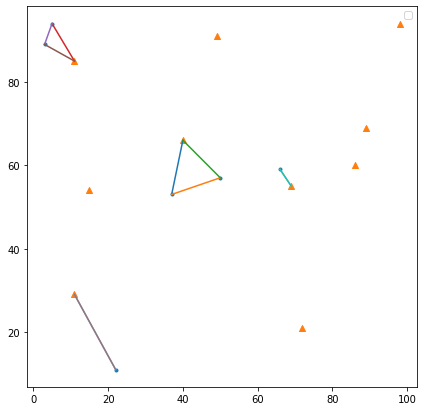

In [477]:
#plotInstance(instance)
day = 3
locs = locationsWithRequest(instance.Locations, filterRequests(instance, day=day))
plotLocations(locs)
#plotInstanceClusters(instance)
locX = [_.X for _ in instance.Locations]
locY = [_.Y for _ in instance.Locations]
nHubs = len(instance.Hubs)
#plt.scatter(locX[0], locY[0], marker=",", label="Depot")
plt.scatter(locX[1:1+nHubs], locY[1:1+nHubs],marker="^", label="Hub")
for hub in  res[day]:
    for route in res[day][hub]['routes']:
        plotRoute(instance.Locations, res[day][hub]['routes'][route], hub=None)

In [431]:
instance.VanDayCost

1000

In [472]:
instance.Requests[0].amounts

[0, 0, 4]